In [2]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../")
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch
torch.cuda.empty_cache()
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
import functools
torch.cuda.set_device(device)
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

import numpy as np
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

from models import utils as mutils
from models import ncsnpp
from sde_lib import VESDE
import datasets



from configs.ve import ffhq_256_ncsnpp_continuous as configs

checkpoint_filepath = cfg["checkpoint_filepath"]
config = configs.get_config()
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
sampling_eps = 1e-5

config.training.batch_size = cfg["batch_size"]
config.eval.batch_size = cfg["batch_size"]

random_seed = 0

score_model = mutils.create_model(config)
score_model.eval()

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(checkpoint_filepath, state, config.device)
ema.copy_to(score_model.parameters())

/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-06-04 08:43:55.551821: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
#@title Visualization code

def image_grid(x):
    size = config.data.image_size
    channels = config.data.num_channels
    img = x.reshape(-1, size, size, channels)
    w = int(np.sqrt(img.shape[0]))
    img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
    return img

def show_samples(x):
    x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
    img = image_grid(x)
    plt.figure(figsize=(3,3))
    plt.axis('off')
    plt.imshow(img)
    plt.show()


In [5]:
# colors = np.ones((1, 100, 100, 1, 3), dtype=np.float32)  # (N, H, W, K, C)
# is_background = np.ones((1, 100, 100), dtype=np.uint8)
# background_color = torch.tensor([0.5, 0.5, 0.5], dtype=torch.float32).to(device)
# # background_image = torch.tensor()

# for i in range(30, 70):
#     for j in range(30, 70):
#         colors[0, i, j, 0, :] = 0
#         is_background[0, i, j] = 0

# colors = torch.tensor(colors, device=device, dtype=torch.float32)
# is_background = torch.tensor(is_background, device=device)
# num_background_pixels = int(is_background.sum().detach().cpu().numpy())

# pixel_colors = colors[..., 0, :].masked_scatter(
#         is_background[..., None],
#         background_color[None, :].expand(num_background_pixels, -1),
# )


In [5]:
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import Textures
from pytorch3d.structures import Meshes
from pytorch3d.renderer.mesh.shader import ShaderBase
from pytorch3d.renderer.mesh.rasterizer import Fragments
from pytorch3d.renderer.mesh.shading import phong_shading
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer
)

def hard_rgb_blend(
    colors: torch.Tensor, backgrounds: torch.Tensor, fragments
) -> torch.Tensor:
    """
    Naive blending of top K faces to return an RGBA image
      - **RGB** - choose color of the closest point i.e. K=0
      - **A** - 1.0

    Args:
        colors: (N, H, W, K, 3) RGB color for each of the top K faces per pixel.
        fragments: the outputs of rasterization. From this we use
            - pix_to_face: LongTensor of shape (N, H, W, K) specifying the indices
              of the faces (in the packed representation) which
              overlap each pixel in the image. This is used to
              determine the output shape.
        blend_params: BlendParams instance that contains a background_color
        field specifying the color for the background
    Returns:
        RGBA pixel_colors: (N, H, W, 4)
    """
    # N, H, W, K = fragments.pix_to_face.shape
    # device = fragments.pix_to_face.device

    # Mask for the background.
    is_background = (fragments.pix_to_face[..., 0] < 0)
    mask = is_background.unsqueeze(-1).repeat(1, 1, 1, 3)  # (N, H, W, 3)

    # background_color_ = blend_params.background_color
    # if isinstance(background_color_, torch.Tensor):
    #     background_color = background_color_.to(device)
    # else:
    #     background_color = colors.new_tensor(background_color_)

    # Find out how much background_color needs to be expanded to be used for masked_scatter.
    # num_background_pixels = is_background.sum()

    # Set background color.
    # pixel_colors = colors[..., 0, :].masked_scatter(
    #     is_background[..., None],
    #     background_color[None, :].expand(num_background_pixels, -1),
    # )  # (N, H, W, 3)

    pixel_colors = torch.where(mask, backgrounds, colors[..., 0, :])

    # Concat with the alpha channel.
    alpha = (~is_background).type_as(pixel_colors)[..., None]

    return torch.cat([pixel_colors, alpha], dim=-1)  # (N, H, W, 4)


class HardPhongShader(ShaderBase):
    """
    Per pixel lighting - the lighting model is applied using the interpolated
    coordinates and normals for each pixel. The blending function hard assigns
    the color of the closest face for each pixel.
    To use the default values, simply initialize the shader with the desired
    device e.g.
    .. code-block::
        shader = HardPhongShader(device=torch.device("cuda:0"))
    """
    def __init__(self, backgrounds, *args, **kwargs):
        self.backgrounds = backgrounds
        super().__init__(*args, **kwargs)

    def forward(self, fragments: Fragments, meshes: Meshes, **kwargs) -> torch.Tensor:
        cameras = kwargs.get("cameras", self.cameras)
        texels = meshes.sample_textures(fragments)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        backgrounds = kwargs.get("backgrounds", self.backgrounds)
        colors = phong_shading(
            meshes=meshes,
            fragments=fragments,
            texels=texels,
            lights=lights,
            cameras=cameras,
            materials=materials,
        )
        images = hard_rgb_blend(colors, backgrounds, fragments)
        return images


class Renderer(object):
    def __init__(self, device):
        self.raster_settings = RasterizationSettings(
            image_size=256,
            blur_radius=0.0,
            bin_size=0,
        )
        obj_path = "../assets/20705.obj"
        self.verts, self.faces, self.aux = load_obj(obj_path, device=device)
        self.verts_uvs = self.aux.verts_uvs[None, ...]  # (1, V, 2)
        self.faces_uvs = self.faces.textures_idx[None, ...]  # (1, F, 3)

    def render(self, texture, background, predict, rsde, vec_t, z, elev, azimuth):
        """
            Inputs:
                texture: torch.tensor with shape (N, C, H, W)
                background: torch.tensor with shape (N, C, H, W)
                elev: float
                azimuth: float
                i: int
                vec_t : torch.Tensor
                rsde: RSDE
                z: torch.Tensor
                noise_face: torch.Tensor
            Outputs:
                face images: (N, C, H, W)
        """
        texture = texture.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        background = background.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        tex = Textures(verts_uvs=self.verts_uvs, faces_uvs=self.faces_uvs, maps=texture)
        meshes = Meshes(verts=[self.verts], faces=[self.faces.verts_idx], textures=tex)
        verts_packed = meshes.verts_packed()
        center = verts_packed.mean(0)
        scale = max((verts_packed - center).abs().max(0)[0])
        meshes.offset_verts_(-center)
        meshes.scale_verts_((1.0 / float(scale)))
        R, T = look_at_view_transform(2.0, elev, azimuth)
        cameras = FoVPerspectiveCameras(R=R, T=T, device=device) # , znear=1, zfar=10000, fov=40, degrees=True, device=device)
        # lights = PointLights(diffuse_color=((0.7, 0.7, 0.7),), ambient_color=((0.2, 0.2, 0.2),), device=device, location=T)
        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras, 
                raster_settings=self.raster_settings
            ),
            shader=HardPhongShader(
                device=device, 
                cameras=cameras,
                backgrounds=background
            )
        )
        face = renderer(meshes)[:, :, :, :3].permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        # if predict:
        #     f, G = rsde.discretize(face.detach(), vec_t)
        #     face_mean = face - f
        #     face = face_mean + G[:, None, None, None] * z

        return face



In [7]:
# import cv2
# from PIL import Image

# renderer = Renderer(device=device)
# # obj_path = "../assets/20705.obj"
# # verts, faces, aux = load_obj(obj_path, device=device)
# # verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
# # faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)
# # tex_maps = aux.texture_images
# # texture = list(tex_maps.values())[0]
# shape = (cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"])
# texture = torch.zeros(size=shape, device=device)
# background = torch.randn(size=shape, device=device)
# Image.fromarray(np.array(renderer.render(texture=texture, background=background, elev=0, azimuth=0)[0].permute(1, 2, 0).detach().cpu().numpy() * 255.0, dtype=np.uint8))

## Unconditional Texture Generation

In [8]:
# initial_texture = "image"
# initial_background = "random"
# optimize_texture = False
# optimize_background = True

# snr = 0.075
# n_steps = 1
# probability_flow = False
# continuous = config.training.continuous
# denoise = True
# renderer = Renderer(device=device)

# def get_initial_texture(initial_texture):
#     if initial_texture == "black":
#         return torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device)
#     elif initial_texture == "random":
#         return torch.randn(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device) * sde.sigma_max
#     elif initial_texture == "image":
#         obj_path = "../assets/20705.obj"
#         _, _, aux = load_obj(obj_path, device=device)
#         tex_maps = aux.texture_images
#         texture = list(tex_maps.values())[0]
#         return torch.tensor(texture, device=device).permute(2, 0, 1)[None, ...]

# def get_initial_background(initial_background):
#     if initial_background == "black":
#         return torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device)
#     elif initial_background == "random":
#         return torch.randn(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device) * sde.sigma_max

# def get_random_elev_azimuth():
#     elev = 0.0 # (np.random.random() * 30) - 60
#     azimuth = 0.0 # (np.random.random() * 30) - 60
#     return elev, azimuth

# def get_grad_texture_and_background(texture, background, elev, azimuth, grad_face, renderer):
#     render_partial = functools.partial(renderer.render, elev=elev, azimuth=azimuth)
#     _, (grad_texture, grad_background) = torch.autograd.functional.vjp(func=render_partial, inputs=(texture, background), v=grad_face, create_graph=False, strict=False)
#     return grad_texture, grad_background

# with torch.no_grad():
#     # Initial sample
#     texture = get_initial_texture(initial_texture)
#     background = get_initial_background(initial_background)
#     elev, azimuth = get_random_elev_azimuth()
#     face = renderer.render(texture=texture, background=background, elev=elev, azimuth=azimuth).detach()
#     print("Showing initial face:")
#     show_samples(face)
#     timesteps = torch.linspace(sde.T, sampling_eps, sde.N, device=device)
#     score_fn = mutils.get_score_fn(sde, score_model, train=False, continuous=continuous)
#     rsde = sde.reverse(score_fn, probability_flow)

#     for i in tqdm(list(range(sde.N))):
#         t = timesteps[i]
#         vec_t = torch.ones(cfg["batch_size"], device=device) * t
#         alpha = torch.ones_like(vec_t, device=device)

#         for _ in range(n_steps):
#             grad_face = score_fn(face, vec_t)
#             grad_texture, grad_background = get_grad_texture_and_background(texture=texture, background=background, elev=elev, azimuth=azimuth, grad_face=grad_face, renderer=renderer)

#             if optimize_texture:
#                 noise_texture = torch.randn_like(texture, device=device)
#                 grad_norm_texture = torch.norm(grad_texture.reshape(grad_texture.shape[0], -1), dim=-1).mean()
#                 noise_norm_texture = torch.norm(noise_texture.reshape(noise_texture.shape[0], -1), dim=-1).mean()
#                 step_size_texture = (snr * noise_norm_texture / grad_norm_texture) ** 2 * 2 * alpha
#                 texture_mean = texture + step_size_texture[:, None, None, None] * grad_texture
#                 texture = texture_mean + torch.sqrt(step_size_texture * 2)[:, None, None, None] * noise_texture
            
#             if optimize_background:
#                 noise_background = torch.randn_like(background, device=device)
#                 grad_norm_background = torch.norm(grad_background.reshape(grad_background.shape[0], -1), dim=-1).mean()
#                 noise_norm_background = torch.norm(noise_background.reshape(noise_background.shape[0], -1), dim=-1).mean()
#                 step_size_background = (snr * noise_norm_background / grad_norm_background) ** 2 * 2 * alpha
#                 background_mean = background + step_size_background[:, None, None, None] * grad_background
#                 background = background_mean + torch.sqrt(step_size_background * 2)[:, None, None, None] * noise_background

#             elev, azimuth = get_random_elev_azimuth()
#             face = renderer.render(texture=texture.detach(), background=background.detach(), elev=elev, azimuth=azimuth).detach()
        
#         f, G = rsde.discretize(face, vec_t)
#         z = torch.randn_like(face)
#         face_mean = face - f
#         face = face_mean + G[:, None, None, None] * z

#     face = inverse_scaler(face_mean if denoise else face)
#     print("Showing final face:")
#     show_samples(face)

#     texture = inverse_scaler(texture_mean if (denoise and optimize_texture) else texture)
#     print("Showing final texture:")
#     show_samples(texture)

#     background = inverse_scaler(background_mean if (denoise and optimize_background) else background)
#     print("Showing final background:")
#     show_samples(background)

#     print("Number of steps:", sde.N * n_steps)



## Unconditional Face Generation

In [9]:
# initial_face = "random"
# initial_background = "random"
# optimize_face = True
# optimize_background = False

# snr = 0.075
# n_steps = 1
# probability_flow = False
# continuous = config.training.continuous
# denoise = True

# def get_initial_face(initial_face):
#     if initial_face == "black":
#         face = torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device)
#     elif initial_face == "random":
#         face = torch.randn(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device) * sde.sigma_max
#     elif initial_face == "image":
#         obj_path = "../assets/20705.obj"
#         _, _, aux = load_obj(obj_path, device=device)
#         tex_maps = aux.texture_images
#         texture = list(tex_maps.values())[0]
#         texture = texture.to(device).permute(2, 0, 1)[None, ...]
#         background = torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device)
#         face = renderer.render(texture=texture, background=background, elev=elev, azimuth=azimuth)
#     return face  # (N, C, H, W)

# def get_initial_background(initial_background):
#     if initial_background == "black":
#         background = torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device)
#     elif initial_background == "random":
#         background = torch.randn(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device) * sde.sigma_max
#     return background  # (N, C, H, W)

# def get_foreground_mask():
#     obj_path = "../assets/20705.obj"
#     _, _, aux = load_obj(obj_path, device=device)
#     tex_maps = aux.texture_images
#     texture = list(tex_maps.values())[0]
#     texture = torch.tensor(texture, device=device).permute(2, 0, 1)[None, ...]
#     background = torch.zeros(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device)
#     face = renderer.render(texture=texture, background=background, elev=elev, azimuth=azimuth)
#     face = (face * 255)
#     foreground_mask = face == face # face > 0
#     return foreground_mask  # (N, C, H, W)

# def get_concatted_face_and_background(face, background, foreground_mask):
#     return torch.where(foreground_mask, face, background)

# def get_grad_face_and_background(face, background, grad_all, foreground_mask):
#     func_partial = functools.partial(get_concatted_face_and_background, foreground_mask=foreground_mask)
#     _, (grad_face, grad_background) = torch.autograd.functional.vjp(func=func_partial, inputs=(face, background), v=grad_all, create_graph=False, strict=False)
#     return grad_face, grad_background

# with torch.no_grad():
#     # Initial sample
#     face = get_initial_face(initial_face)
#     background = get_initial_background(initial_background)
#     foreground_mask = get_foreground_mask()
#     all = get_concatted_face_and_background(face, background, foreground_mask)
#     print("Showing initial all:")
#     show_samples(all)
#     timesteps = torch.linspace(sde.T, sampling_eps, sde.N, device=device)
#     score_fn = mutils.get_score_fn(sde, score_model, train=False, continuous=continuous)
#     rsde = sde.reverse(score_fn, probability_flow)

#     for i in tqdm(list(range(sde.N))):
#         t = timesteps[i]
#         vec_t = torch.ones(cfg["batch_size"], device=device) * t
#         alpha = torch.ones_like(vec_t, device=device)

#         for _ in range(n_steps):
#             grad_all = score_fn(all, vec_t)
#             grad_face, grad_background = get_grad_face_and_background(face, background, grad_all, foreground_mask)

#             if optimize_face:
#                 noise_face = torch.randn_like(face, device=device)
#                 grad_norm_face = torch.norm(grad_face.reshape(grad_face.shape[0], -1), dim=-1).mean()
#                 noise_norm_face = torch.norm(noise_face.reshape(noise_face.shape[0], -1), dim=-1).mean()
#                 step_size_face = (snr * noise_norm_face / grad_norm_face) ** 2 * 2 * alpha
#                 face_mean = face + step_size_face[:, None, None, None] * grad_face
#                 face = face_mean + torch.sqrt(step_size_face * 2)[:, None, None, None] * noise_face

#             if optimize_background:
#                 noise_background = torch.randn_like(background, device=device)
#                 grad_norm_background = torch.norm(grad_background.reshape(grad_background.shape[0], -1), dim=-1).mean()
#                 noise_norm_background = torch.norm(noise_background.reshape(noise_background.shape[0], -1), dim=-1).mean()
#                 step_size_background = (snr * noise_norm_background / grad_norm_background) ** 2 * 2 * alpha
#                 background_mean = background + step_size_background[:, None, None, None] * grad_background
#                 background = background_mean + torch.sqrt(step_size_background * 2)[:, None, None, None] * noise_background

#             all = get_concatted_face_and_background(face, background, foreground_mask)

#         f, G = rsde.discretize(all, vec_t)
#         z = torch.randn_like(all)
#         all_mean = all - f
#         all = all_mean + G[:, None, None, None] * z

#     all = inverse_scaler(all_mean if denoise else all)
#     print("Showing final all:")
#     show_samples(all)

#     face = inverse_scaler(face_mean if (denoise and optimize_face) else face)
#     print("Showing final face:")
#     show_samples(face)

#     background = inverse_scaler(background_mean if (denoise and optimize_background) else background)
#     print("Showing final background:")
#     show_samples(background)

#     print("Number of steps:", sde.N * n_steps)



In [10]:
# snr = 0.075
# n_steps = 1
# probability_flow = False
# continuous = config.training.continuous
# denoise = True

# def score_fn(x, vec_t):
#     labels = sde.marginal_prob(torch.zeros_like(x), vec_t)[1]
#     score = score_model(x, labels)
#     return score

# with torch.no_grad():
#     # Initial sample
#     face = torch.randn(size=(cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"]), device=device) * sde.sigma_max
#     timesteps = torch.linspace(sde.T, sampling_eps, sde.N, device=device)
#     rsde = sde.reverse(score_fn, probability_flow)

#     for i in tqdm(list(range(sde.N))):
#         t = timesteps[i]
#         vec_t = torch.ones(cfg["batch_size"], device=device) * t
#         alpha = torch.ones_like(vec_t, device=device)

#         for _ in range(n_steps):
#             grad_face = score_fn(face, vec_t)
#             grad_texture = calculate_grad_texture
#             noise_face = torch.randn_like(face, device=device)
#             grad_norm = torch.norm(grad_face.reshape(grad_face.shape[0], -1), dim=-1).mean()
#             noise_norm = torch.norm(noise_face.reshape(noise_face.shape[0], -1), dim=-1).mean()
#             step_size = (snr * noise_norm / grad_norm) ** 2 * 2 * alpha
#             face_mean = face + step_size[:, None, None, None] * grad_face
#             face = face_mean + torch.sqrt(step_size * 2)[:, None, None, None] * noise_face
        
#         f, G = rsde.discretize(face, vec_t)
#         z = torch.randn_like(face)
#         face_mean = face - f
#         face = face_mean + G[:, None, None, None] * z

#     face = inverse_scaler(face_mean if denoise else face)
#     print("Number of steps:", sde.N * n_steps)

# print("Showing face:")
# show_samples(face)



An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/pytorch3d/io/utils.py:66: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")
  0%|          | 0/2000 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


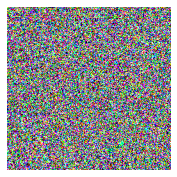

  0%|          | 10/2000 [01:10<3:52:56,  7.02s/it]


KeyboardInterrupt: 

In [6]:
snr = 0.15 # 0.075
n_steps = 20
probability_flow = False
continuous = config.training.continuous
denoise = True
shape = (cfg["batch_size"], cfg["num_channels"], cfg["image_height"], cfg["image_width"])
renderer = Renderer(device=device)


def get_foreground_mask(sde, renderer, elev, azimuth):
    texture = torch.ones(size=shape, device=device)
    background = torch.zeros(size=shape, device=device)
    elev, azimuth = get_random_elev_azimuth()
    face = renderer.render(texture=texture, background=background, elev=elev, azimuth=azimuth)
    foreground_mask = (face > 0)
    return foreground_mask


def fake_render(texture, background, predict, rsde, vec_t, z, foreground_mask=None):
    face = torch.where(foreground_mask, texture, background)

    # if j == n_steps - 1:
    # if predict:
    #     f, G = rsde.discretize(face.detach(), vec_t)
    #     face_mean = face - f
    #     face = face_mean + G[:, None, None, None] * z

        # texture_mean = texture - f
        # texture = texture_mean + G[:, None, None, None] * z

        # background_mean = background - f
        # background = background_mean + G[:, None, None, None] * z 
    return face


def score_fn(x, vec_t):
    labels = sde.marginal_prob(torch.zeros_like(x), vec_t)[1]
    score = score_model(x, labels)
    return score


def get_random_elev_azimuth():
    elev = 0.0  # (np.random.random() * 30) - 60
    azimuth = 0.0  # (np.random.random() * 30) - 60
    return elev, azimuth


def get_grad_texture_and_background(texture, background, grad_face, render_func):
    _, (grad_texture, grad_background) = torch.autograd.functional.vjp(func=render_func, inputs=(texture, background), v=grad_face, create_graph=False, strict=False)
    return grad_texture, grad_background


with torch.no_grad():
    # Initial sample
    texture = torch.randn(size=shape, device=device) * sde.sigma_max
    background = torch.randn(size=shape, device=device) * sde.sigma_max
    # face = renderer.render(texture=texture, background=background, elev=elev, azimuth=azimuth)
    
    timesteps = torch.linspace(sde.T, sampling_eps, sde.N, device=device)
    rsde = sde.reverse(score_fn, probability_flow)
    alpha = torch.ones(cfg["batch_size"], device=device)

    for i in tqdm(list(range(sde.N))):
        for j in range(n_steps):
            t = timesteps[i]
            vec_t = torch.ones(cfg["batch_size"], device=device) * t
            labels = sde.marginal_prob(torch.zeros(size=shape), vec_t)[1]

            elev, azimuth = get_random_elev_azimuth()
            # foreground_mask = get_foreground_mask(sde, renderer, elev, azimuth)
            z = torch.randn(size=shape, device=device)
            face = renderer.render(texture, background, predict=(j == n_steps - 1), rsde=rsde, vec_t=vec_t, z=z, elev=elev, azimuth=azimuth)
            # face = fake_render(texture, background, predict=(j == n_steps - 1), z=z, foreground_mask=foreground_mask)

            grad_face = score_model(face, labels)
            grad_face_norm = torch.norm(grad_face.reshape(grad_face.shape[0], -1), dim=-1).mean()

            # noise_face = torch.randn(size=shape, device=device)
            # noise_face_norm = torch.norm(noise_face.reshape(noise_face.shape[0], -1), dim=-1).mean()
            noise_texture = torch.randn(size=shape, device=device)
            noise_texture_norm = torch.norm(noise_texture.reshape(noise_texture.shape[0], -1), dim=-1).mean()
            noise_background = torch.randn(size=shape, device=device)
            noise_background_norm = torch.norm(noise_background.reshape(noise_background.shape[0], -1), dim=-1).mean()

            render_func = functools.partial(renderer.render, predict=(j == n_steps - 1), rsde=rsde, vec_t=vec_t, z=z, elev=elev, azimuth=azimuth)
            # render_func = functools.partial(fake_render, predict=(j == n_steps - 1), z=z, foreground_mask=foreground_mask)

            grad_texture, grad_background = get_grad_texture_and_background(texture, background, grad_face, render_func)
            grad_texture_norm = torch.norm(grad_texture.reshape(grad_texture.shape[0], -1), dim=-1).mean()
            grad_background_norm = torch.norm(grad_background.reshape(grad_background.shape[0], -1), dim=-1).mean()

            # step_size = (snr * noise_face_norm / grad_face_norm) ** 2 * 2 * alpha
            texture_step_size = (snr * noise_texture_norm / grad_texture_norm) ** 2 * 2 * alpha
            background_step_size = (snr * noise_background_norm / grad_background_norm) ** 2 * 2 * alpha

            texture_mean = texture + texture_step_size[:, None, None, None] * grad_texture
            background_mean = background + background_step_size[:, None, None, None] * grad_background

            texture = texture_mean + torch.sqrt(texture_step_size * 2)[:, None, None, None] * noise_texture
            background = background_mean + torch.sqrt(background_step_size * 2)[:, None, None, None] * noise_background

        if i % 200 == 0:
            show_samples(renderer.render(texture_mean, background_mean, predict=False, rsde=None, vec_t=None, z=None, elev=elev, azimuth=azimuth))
            # show_samples(fake_render(texture_mean, background_mean, predict=False, z=None, foreground_mask=foreground_mask))

    print("Number of steps:", sde.N * n_steps)

print("Showing face:")
show_samples(renderer.render(texture_mean, background_mean, predict=False, rsde=None, vec_t=None, z=None, elev=elev, azimuth=azimuth))
# show_samples(fake_render(texture_mean, background_mean, predict=False, z=None, foreground_mask=foreground_mask))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


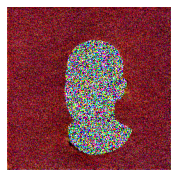

In [ ]:
show_samples(background_mean)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


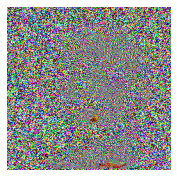

In [ ]:
show_samples(texture_mean)